In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/sisa

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 278 (delta 12), reused 44 (delta 9), pack-reused 206 (from 1)
Receiving objects: 100% (278/278), 227.58 MiB | 22.90 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Updating files: 100% (71/71), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/sisa


## Dependencies

In [1]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils

In [2]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: D:\Machine_unlearning_masters


In [3]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Init model
from models.effnetb0 import init_model_effnetb0

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cpu


## Parameters (arbitrary chosen)

In [4]:
BATCH_SIZE = 32

LEARNING_RATE = 0.001

EPOCHS = 5

SHARDS = 3

SLICES = 5

# SISA structure

## Get data transform

In [6]:
*_, transform = init_model_effnetb0()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


Done initializing model.
Model ID: 135575560302176, Optimizer ID: 135575560301792, Criterion ID: 135575560301648


## Load dataset

In [7]:
data_root = Path('/kaggle/input/animal-faces') # Only add if in kaggle env

In [8]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Create SISA structure

In [9]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES)

SISA structure saved to sisa_structure.json


In [10]:
sisa_structure_file = 'sisa_structure.json'

## Prepare DataLoaders from json file

In [30]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

# Train using SISA framework

## Models output path

In [12]:
save_models_metrics_dir = './sisa_models'

## Call train

In [13]:
sisa_train(
    dataloaders=dataloaders, 
    num_epochs=EPOCHS, 
    save_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    learning_rate=LEARNING_RATE,
    )

Training shard: shard_0
Init model...
Done initializing model.
Model ID: 135575560365600, Optimizer ID: 135575560371792, Criterion ID: 135575560371840
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch [1/5], Train Loss: 0.2452, Train Accuracy: 0.9226, Val Loss: 0.0051, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch [2/5], Train Loss: 0.0810, Train Accuracy: 0.9738, Val Loss: 0.0050, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch [3/5], Train Loss: 0.0455, Train Accuracy: 0.9841, Val Loss: 0.0053, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch [4/5], Train Loss: 0.0198, Train Accuracy: 0.9954, Val Loss: 0.0151, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch [5/5], Train Loss: 0.0201, Train Accuracy: 0.9932, Val Loss: 0.0064, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch [1/5], Train Loss: 0.0332, Train Accuracy: 0.9909, Val Loss: 0.0110, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch [2/5], Train Loss: 0.0485, Train Accuracy: 0.9852, Val Loss: 0.0104, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch [3/5], Train Loss: 0.0563, Train Accuracy: 0.9806, Val Loss: 0.1487, Val Accuracy: 0.9691


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch [4/5], Train Loss: 0.0562, Train Accuracy: 0.9829, Val Loss: 0.0243, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch [5/5], Train Loss: 0.0181, Train Accuracy: 0.9920, Val Loss: 0.0137, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch [1/5], Train Loss: 0.0516, Train Accuracy: 0.9841, Val Loss: 0.0269, Val Accuracy: 0.9794
Epoch 1: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch [2/5], Train Loss: 0.0161, Train Accuracy: 0.9943, Val Loss: 0.0391, Val Accuracy: 0.9897
Epoch 2: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch [3/5], Train Loss: 0.0100, Train Accuracy: 0.9966, Val Loss: 0.0126, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch [4/5], Train Loss: 0.0183, Train Accuracy: 0.9909, Val Loss: 0.0044, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch [5/5], Train Loss: 0.0025, Train Accuracy: 1.0000, Val Loss: 0.0029, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch [1/5], Train Loss: 0.0519, Train Accuracy: 0.9875, Val Loss: 0.0484, Val Accuracy: 0.9794
Epoch 1: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch [2/5], Train Loss: 0.0331, Train Accuracy: 0.9863, Val Loss: 0.0015, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch [3/5], Train Loss: 0.0185, Train Accuracy: 0.9954, Val Loss: 0.0093, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch [4/5], Train Loss: 0.0119, Train Accuracy: 0.9966, Val Loss: 0.0007, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch [5/5], Train Loss: 0.0128, Train Accuracy: 0.9954, Val Loss: 0.0020, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Epoch [1/5], Train Loss: 0.0402, Train Accuracy: 0.9898, Val Loss: 0.1779, Val Accuracy: 0.9381
Epoch 1: New best validation accuracy: 0.9381. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch [2/5], Train Loss: 0.0194, Train Accuracy: 0.9943, Val Loss: 0.0456, Val Accuracy: 0.9897
Epoch 2: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Epoch [3/5], Train Loss: 0.0252, Train Accuracy: 0.9909, Val Loss: 0.0925, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch [4/5], Train Loss: 0.0064, Train Accuracy: 0.9989, Val Loss: 0.0805, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch [5/5], Train Loss: 0.0026, Train Accuracy: 0.9989, Val Loss: 0.0727, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_0_final_model.pth
Training shard: shard_1
Init model...
Done initializing model.
Model ID: 135575473364208, Optimizer ID: 135575560217712, Criterion ID: 135575560218000
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch [1/5], Train Loss: 0.2009, Train Accuracy: 0.9351, Val Loss: 0.1025, Val Accuracy: 0.9794
Epoch 1: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch [2/5], Train Loss: 0.0968, Train Accuracy: 0.9601, Val Loss: 0.0466, Val Accuracy: 0.9897
Epoch 2: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch [3/5], Train Loss: 0.0599, Train Accuracy: 0.9818, Val Loss: 0.0659, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch [4/5], Train Loss: 0.0452, Train Accuracy: 0.9897, Val Loss: 0.0530, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Epoch [5/5], Train Loss: 0.0267, Train Accuracy: 0.9943, Val Loss: 0.1907, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch [1/5], Train Loss: 0.0778, Train Accuracy: 0.9647, Val Loss: 0.0314, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch [2/5], Train Loss: 0.0493, Train Accuracy: 0.9863, Val Loss: 0.0208, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch [3/5], Train Loss: 0.0093, Train Accuracy: 0.9989, Val Loss: 0.0026, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Epoch [4/5], Train Loss: 0.0085, Train Accuracy: 0.9977, Val Loss: 0.0056, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch [5/5], Train Loss: 0.0101, Train Accuracy: 0.9966, Val Loss: 0.0245, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Epoch [1/5], Train Loss: 0.0682, Train Accuracy: 0.9863, Val Loss: 0.0764, Val Accuracy: 0.9794
Epoch 1: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch [2/5], Train Loss: 0.0262, Train Accuracy: 0.9932, Val Loss: 0.0577, Val Accuracy: 0.9897
Epoch 2: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch [3/5], Train Loss: 0.0134, Train Accuracy: 0.9966, Val Loss: 0.0976, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch [4/5], Train Loss: 0.0041, Train Accuracy: 0.9989, Val Loss: 0.0331, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Epoch [5/5], Train Loss: 0.0056, Train Accuracy: 0.9989, Val Loss: 0.0405, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch [1/5], Train Loss: 0.0653, Train Accuracy: 0.9738, Val Loss: 0.0887, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch [2/5], Train Loss: 0.0540, Train Accuracy: 0.9829, Val Loss: 0.1203, Val Accuracy: 0.9588


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch [3/5], Train Loss: 0.0381, Train Accuracy: 0.9909, Val Loss: 0.0496, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch [4/5], Train Loss: 0.0193, Train Accuracy: 0.9932, Val Loss: 0.2150, Val Accuracy: 0.9691


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch [5/5], Train Loss: 0.0186, Train Accuracy: 0.9932, Val Loss: 0.0559, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch [1/5], Train Loss: 0.0810, Train Accuracy: 0.9750, Val Loss: 0.0310, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch [2/5], Train Loss: 0.0195, Train Accuracy: 0.9909, Val Loss: 0.0034, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch [3/5], Train Loss: 0.0029, Train Accuracy: 0.9989, Val Loss: 0.0103, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Epoch [4/5], Train Loss: 0.0015, Train Accuracy: 1.0000, Val Loss: 0.0069, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch [5/5], Train Loss: 0.0007, Train Accuracy: 1.0000, Val Loss: 0.0025, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_1_final_model.pth
Training shard: shard_2
Init model...
Done initializing model.
Model ID: 135575560368096, Optimizer ID: 135575556073376, Criterion ID: 135575556069536
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch [1/5], Train Loss: 0.2137, Train Accuracy: 0.9282, Val Loss: 0.0860, Val Accuracy: 0.9485
Epoch 1: New best validation accuracy: 0.9485. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch [2/5], Train Loss: 0.0671, Train Accuracy: 0.9784, Val Loss: 0.0601, Val Accuracy: 0.9691
Epoch 2: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch [3/5], Train Loss: 0.0580, Train Accuracy: 0.9806, Val Loss: 0.0209, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Epoch [4/5], Train Loss: 0.0573, Train Accuracy: 0.9863, Val Loss: 0.0322, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch [5/5], Train Loss: 0.0315, Train Accuracy: 0.9897, Val Loss: 0.0415, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch [1/5], Train Loss: 0.0587, Train Accuracy: 0.9761, Val Loss: 0.0061, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch [2/5], Train Loss: 0.0359, Train Accuracy: 0.9897, Val Loss: 0.0015, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch [3/5], Train Loss: 0.0406, Train Accuracy: 0.9875, Val Loss: 0.0011, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Epoch [4/5], Train Loss: 0.0249, Train Accuracy: 0.9886, Val Loss: 0.0004, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch [5/5], Train Loss: 0.0217, Train Accuracy: 0.9932, Val Loss: 0.0111, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch [1/5], Train Loss: 0.0538, Train Accuracy: 0.9795, Val Loss: 0.0548, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch [2/5], Train Loss: 0.0277, Train Accuracy: 0.9875, Val Loss: 0.1332, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Epoch [3/5], Train Loss: 0.0180, Train Accuracy: 0.9932, Val Loss: 0.0223, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch [4/5], Train Loss: 0.0169, Train Accuracy: 0.9966, Val Loss: 0.0827, Val Accuracy: 0.9691


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch [5/5], Train Loss: 0.0184, Train Accuracy: 0.9954, Val Loss: 0.1218, Val Accuracy: 0.9588
Training complete for ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch [1/5], Train Loss: 0.0633, Train Accuracy: 0.9863, Val Loss: 0.0210, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch [2/5], Train Loss: 0.0245, Train Accuracy: 0.9920, Val Loss: 0.0216, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


Epoch [3/5], Train Loss: 0.0098, Train Accuracy: 0.9966, Val Loss: 0.0096, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch [4/5], Train Loss: 0.0325, Train Accuracy: 0.9920, Val Loss: 0.0010, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch [5/5], Train Loss: 0.0139, Train Accuracy: 0.9966, Val Loss: 0.0795, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch [1/5], Train Loss: 0.0439, Train Accuracy: 0.9841, Val Loss: 0.1030, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch [2/5], Train Loss: 0.0212, Train Accuracy: 0.9932, Val Loss: 0.2171, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch [3/5], Train Loss: 0.0192, Train Accuracy: 0.9955, Val Loss: 0.0107, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch [4/5], Train Loss: 0.0040, Train Accuracy: 1.0000, Val Loss: 0.0040, Val Accuracy: 1.0000
Epoch 4: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

Epoch [5/5], Train Loss: 0.0022, Train Accuracy: 1.0000, Val Loss: 0.0016, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_2_final_model.pth


## Call test

In [14]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 135575555982528, Optimizer ID: 135575555996544, Criterion ID: 135575555989824
Loading and testing model: ./sisa_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_0_final_model.pth: 100%|██████████| 47/47 [00:17<00:00,  2.69it/s]


Predictions and labels saved to ./sisa_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135575556114704, Optimizer ID: 135575556117632, Criterion ID: 135575556117680
Loading and testing model: ./sisa_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_1_final_model.pth: 100%|██████████| 47/47 [00:11<00:00,  4.22it/s]


Predictions and labels saved to ./sisa_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135575560368096, Optimizer ID: 135575560371696, Criterion ID: 135575560369968
Loading and testing model: ./sisa_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_2_final_model.pth: 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]

Predictions and labels saved to ./sisa_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [ ]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

# classes = ['cat', 'dog', 'wildlife']

Shard shard_0 Metrics:
  Accuracy: 0.9960
  Precision: 0.9960
  Recall: 0.9960
  F1 Score: 0.9960
Shard shard_1 Metrics:
  Accuracy: 0.9960
  Precision: 0.9960
  Recall: 0.9960
  F1 Score: 0.9960
Shard shard_2 Metrics:
  Accuracy: 0.9947
  Precision: 0.9947
  Recall: 0.9947
  F1 Score: 0.9947

Aggregated Model Metrics:
  Accuracy: 0.9967
  Precision: 0.9967
  Recall: 0.9967
  F1 Score: 0.9967


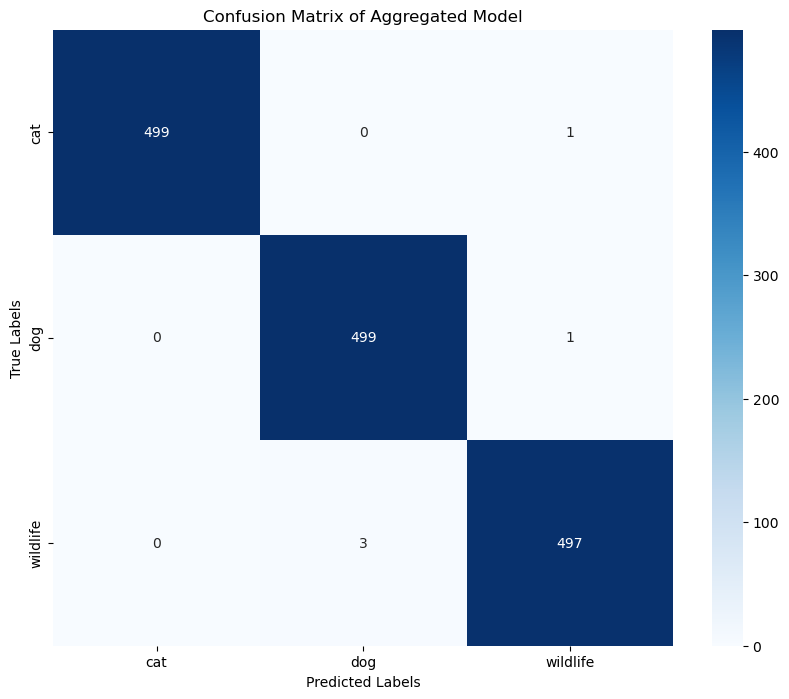

In [7]:
evaluate_aggregated_model(results, classes)

# SISA re-train

## Paths to data info

In [17]:
samples_to_delete = project_root/'experiments/animal_faces/naive/afhq_samples_to_unlearn.json'
sisa_structure = 'sisa_structure.json'
updated_sisa_structure = 'updated_sisa_strucute.json'
deleted_samples = 'deleted_samples.json'

## Update sisa structure -> delete samples 

In [18]:
affected_shards = update_sisa_structure(samples_to_delete, sisa_structure, updated_sisa_structure,deleted_samples)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file

In [19]:
dataloaders = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

## Models output path

In [20]:
save_path = "./sisa_updated_models"

## Retrain the affected shards

In [21]:
retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_effnetb0, 
    learning_rate=LEARNING_RATE
)

Retraining shard: shard_0
Init model...
Done initializing model.
Model ID: 135575560361664, Optimizer ID: 135575560361232, Criterion ID: 135575560361616
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch [1/5], Train Loss: 0.2655, Train Accuracy: 0.8990, Val Loss: 0.0405, Val Accuracy: 0.9886
Epoch 1: New best validation accuracy: 0.9886. Model saved to ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Epoch [2/5], Train Loss: 0.0717, Train Accuracy: 0.9722, Val Loss: 0.0172, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch [3/5], Train Loss: 0.0468, Train Accuracy: 0.9848, Val Loss: 0.1572, Val Accuracy: 0.9545


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Epoch [4/5], Train Loss: 0.0395, Train Accuracy: 0.9937, Val Loss: 0.0406, Val Accuracy: 0.9773


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch [5/5], Train Loss: 0.0566, Train Accuracy: 0.9861, Val Loss: 0.0334, Val Accuracy: 0.9886
Training complete for ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


Epoch [1/5], Train Loss: 0.0881, Train Accuracy: 0.9673, Val Loss: 0.1366, Val Accuracy: 0.9432
Epoch 1: New best validation accuracy: 0.9432. Model saved to ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [2/5], Train Loss: 0.0581, Train Accuracy: 0.9824, Val Loss: 0.0067, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch [3/5], Train Loss: 0.0320, Train Accuracy: 0.9912, Val Loss: 0.0050, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch [4/5], Train Loss: 0.0201, Train Accuracy: 0.9937, Val Loss: 0.0093, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [5/5], Train Loss: 0.0055, Train Accuracy: 1.0000, Val Loss: 0.0006, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Epoch [1/5], Train Loss: 0.0411, Train Accuracy: 0.9835, Val Loss: 0.0313, Val Accuracy: 0.9885
Epoch 1: New best validation accuracy: 0.9885. Model saved to ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch [2/5], Train Loss: 0.0466, Train Accuracy: 0.9860, Val Loss: 0.0257, Val Accuracy: 0.9770


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


Epoch [3/5], Train Loss: 0.0112, Train Accuracy: 0.9975, Val Loss: 0.0148, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [4/5], Train Loss: 0.0665, Train Accuracy: 0.9886, Val Loss: 0.1090, Val Accuracy: 0.9425


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Epoch [5/5], Train Loss: 0.0155, Train Accuracy: 0.9962, Val Loss: 0.0198, Val Accuracy: 0.9885
Training complete for ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch [1/5], Train Loss: 0.0400, Train Accuracy: 0.9885, Val Loss: 0.0067, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch [2/5], Train Loss: 0.0537, Train Accuracy: 0.9834, Val Loss: 0.0338, Val Accuracy: 0.9770


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch [3/5], Train Loss: 0.0497, Train Accuracy: 0.9860, Val Loss: 0.0066, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch [4/5], Train Loss: 0.0219, Train Accuracy: 0.9923, Val Loss: 0.0323, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch [5/5], Train Loss: 0.0089, Train Accuracy: 0.9974, Val Loss: 0.0214, Val Accuracy: 0.9885
Training complete for ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Epoch [1/5], Train Loss: 0.0561, Train Accuracy: 0.9758, Val Loss: 0.0296, Val Accuracy: 0.9770
Epoch 1: New best validation accuracy: 0.9770. Model saved to ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch [2/5], Train Loss: 0.0286, Train Accuracy: 0.9924, Val Loss: 0.0908, Val Accuracy: 0.9770


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch [3/5], Train Loss: 0.0021, Train Accuracy: 1.0000, Val Loss: 0.0780, Val Accuracy: 0.9770


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


Epoch [4/5], Train Loss: 0.0023, Train Accuracy: 0.9987, Val Loss: 0.1127, Val Accuracy: 0.9770


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [5/5], Train Loss: 0.0007, Train Accuracy: 1.0000, Val Loss: 0.1068, Val Accuracy: 0.9770
Training complete for ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_0 to ./sisa_updated_models/shard_0_final_model.pth
Retraining shard: shard_1
Init model...
Done initializing model.
Model ID: 135575471319040, Optimizer ID: 135575560364832, Criterion ID: 135575560363824
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Epoch [1/5], Train Loss: 0.2546, Train Accuracy: 0.9198, Val Loss: 0.0160, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


Epoch [2/5], Train Loss: 0.0666, Train Accuracy: 0.9771, Val Loss: 0.0600, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


Epoch [3/5], Train Loss: 0.0565, Train Accuracy: 0.9796, Val Loss: 0.0407, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch [4/5], Train Loss: 0.0412, Train Accuracy: 0.9860, Val Loss: 0.0511, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch [5/5], Train Loss: 0.0415, Train Accuracy: 0.9873, Val Loss: 0.0785, Val Accuracy: 0.9885
Training complete for ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch [1/5], Train Loss: 0.0849, Train Accuracy: 0.9743, Val Loss: 0.0425, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Epoch [2/5], Train Loss: 0.0321, Train Accuracy: 0.9884, Val Loss: 0.0044, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch [3/5], Train Loss: 0.0227, Train Accuracy: 0.9910, Val Loss: 0.0019, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch [4/5], Train Loss: 0.0080, Train Accuracy: 0.9987, Val Loss: 0.0019, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Epoch [5/5], Train Loss: 0.0036, Train Accuracy: 1.0000, Val Loss: 0.0240, Val Accuracy: 0.9884
Training complete for ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Epoch [1/5], Train Loss: 0.0469, Train Accuracy: 0.9912, Val Loss: 0.0105, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Epoch [2/5], Train Loss: 0.0633, Train Accuracy: 0.9773, Val Loss: 0.0013, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch [3/5], Train Loss: 0.0330, Train Accuracy: 0.9874, Val Loss: 0.0800, Val Accuracy: 0.9659


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


Epoch [4/5], Train Loss: 0.0179, Train Accuracy: 0.9924, Val Loss: 0.0524, Val Accuracy: 0.9886


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [5/5], Train Loss: 0.0202, Train Accuracy: 0.9924, Val Loss: 0.0225, Val Accuracy: 0.9773
Training complete for ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [1/5], Train Loss: 0.0366, Train Accuracy: 0.9874, Val Loss: 0.0505, Val Accuracy: 0.9773
Epoch 1: New best validation accuracy: 0.9773. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Epoch [2/5], Train Loss: 0.0085, Train Accuracy: 0.9962, Val Loss: 0.0212, Val Accuracy: 0.9886
Epoch 2: New best validation accuracy: 0.9886. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch [3/5], Train Loss: 0.0042, Train Accuracy: 0.9987, Val Loss: 0.0100, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch [4/5], Train Loss: 0.0232, Train Accuracy: 0.9912, Val Loss: 0.0609, Val Accuracy: 0.9773


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch [5/5], Train Loss: 0.0088, Train Accuracy: 0.9975, Val Loss: 0.0194, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Epoch [1/5], Train Loss: 0.0469, Train Accuracy: 0.9863, Val Loss: 0.0556, Val Accuracy: 0.9775
Epoch 1: New best validation accuracy: 0.9775. Model saved to ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [2/5], Train Loss: 0.0182, Train Accuracy: 0.9925, Val Loss: 0.0362, Val Accuracy: 0.9888
Epoch 2: New best validation accuracy: 0.9888. Model saved to ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch [3/5], Train Loss: 0.0868, Train Accuracy: 0.9750, Val Loss: 0.0205, Val Accuracy: 0.9888


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch [4/5], Train Loss: 0.0597, Train Accuracy: 0.9863, Val Loss: 0.0182, Val Accuracy: 0.9888


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [5/5], Train Loss: 0.0373, Train Accuracy: 0.9888, Val Loss: 0.1062, Val Accuracy: 0.9663
Training complete for ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_1 to ./sisa_updated_models/shard_1_final_model.pth
Retraining shard: shard_2
Init model...
Done initializing model.
Model ID: 135575560363728, Optimizer ID: 135575560359408, Criterion ID: 135575560361616
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Epoch [1/5], Train Loss: 0.2357, Train Accuracy: 0.9322, Val Loss: 0.1072, Val Accuracy: 0.9545
Epoch 1: New best validation accuracy: 0.9545. Model saved to ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [2/5], Train Loss: 0.0616, Train Accuracy: 0.9799, Val Loss: 0.0776, Val Accuracy: 0.9773
Epoch 2: New best validation accuracy: 0.9773. Model saved to ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch [3/5], Train Loss: 0.0639, Train Accuracy: 0.9812, Val Loss: 0.0179, Val Accuracy: 0.9886
Epoch 3: New best validation accuracy: 0.9886. Model saved to ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Epoch [4/5], Train Loss: 0.0189, Train Accuracy: 0.9950, Val Loss: 0.0207, Val Accuracy: 0.9886


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch [5/5], Train Loss: 0.0403, Train Accuracy: 0.9887, Val Loss: 0.0541, Val Accuracy: 0.9773
Training complete for ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Epoch [1/5], Train Loss: 0.1248, Train Accuracy: 0.9597, Val Loss: 0.1085, Val Accuracy: 0.9773
Epoch 1: New best validation accuracy: 0.9773. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Epoch [2/5], Train Loss: 0.0567, Train Accuracy: 0.9811, Val Loss: 0.0464, Val Accuracy: 0.9773


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Epoch [3/5], Train Loss: 0.0481, Train Accuracy: 0.9899, Val Loss: 0.0151, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Epoch [4/5], Train Loss: 0.0215, Train Accuracy: 0.9950, Val Loss: 0.1484, Val Accuracy: 0.9773


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Epoch [5/5], Train Loss: 0.0170, Train Accuracy: 0.9962, Val Loss: 0.0483, Val Accuracy: 0.9773
Training complete for ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch [1/5], Train Loss: 0.0719, Train Accuracy: 0.9848, Val Loss: 0.0200, Val Accuracy: 0.9885
Epoch 1: New best validation accuracy: 0.9885. Model saved to ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Epoch [2/5], Train Loss: 0.0114, Train Accuracy: 0.9987, Val Loss: 0.0008, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch [3/5], Train Loss: 0.0040, Train Accuracy: 0.9987, Val Loss: 0.0031, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Epoch [4/5], Train Loss: 0.0012, Train Accuracy: 1.0000, Val Loss: 0.0013, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch [5/5], Train Loss: 0.0020, Train Accuracy: 1.0000, Val Loss: 0.0003, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Epoch [1/5], Train Loss: 0.0255, Train Accuracy: 0.9898, Val Loss: 0.2572, Val Accuracy: 0.9425
Epoch 1: New best validation accuracy: 0.9425. Model saved to ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch [2/5], Train Loss: 0.0843, Train Accuracy: 0.9759, Val Loss: 0.1669, Val Accuracy: 0.9310


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Epoch [3/5], Train Loss: 0.0202, Train Accuracy: 0.9936, Val Loss: 0.2385, Val Accuracy: 0.9425


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch [4/5], Train Loss: 0.0104, Train Accuracy: 0.9962, Val Loss: 0.1511, Val Accuracy: 0.9655
Epoch 4: New best validation accuracy: 0.9655. Model saved to ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch [5/5], Train Loss: 0.0075, Train Accuracy: 0.9987, Val Loss: 0.2161, Val Accuracy: 0.9540
Training complete for ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch [1/5], Train Loss: 0.0674, Train Accuracy: 0.9798, Val Loss: 0.0599, Val Accuracy: 0.9540
Epoch 1: New best validation accuracy: 0.9540. Model saved to ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Epoch [2/5], Train Loss: 0.0188, Train Accuracy: 0.9937, Val Loss: 0.0254, Val Accuracy: 0.9885
Epoch 2: New best validation accuracy: 0.9885. Model saved to ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch [3/5], Train Loss: 0.0029, Train Accuracy: 1.0000, Val Loss: 0.0209, Val Accuracy: 0.9885


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Epoch [4/5], Train Loss: 0.0016, Train Accuracy: 1.0000, Val Loss: 0.0006, Val Accuracy: 1.0000
Epoch 4: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Epoch [5/5], Train Loss: 0.0050, Train Accuracy: 0.9987, Val Loss: 0.0010, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_2 to ./sisa_updated_models/shard_2_final_model.pth


## Re-test new SISA models

In [22]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_path, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 135575560362720, Optimizer ID: 135575560358640, Criterion ID: 135575560358304
Loading and testing model: ./sisa_updated_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


Predictions and labels saved to ./sisa_updated_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135575459490080, Optimizer ID: 135575459481632, Criterion ID: 135575459486912
Loading and testing model: ./sisa_updated_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


Predictions and labels saved to ./sisa_updated_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135575459467072, Optimizer ID: 135575459467120, Criterion ID: 135575459466352
Loading and testing model: ./sisa_updated_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]

Predictions and labels saved to ./sisa_updated_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [23]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9967
  Precision: 0.9967
  Recall: 0.9967
  F1 Score: 0.9967
Shard shard_1 Metrics:
  Accuracy: 0.9673
  Precision: 0.9702
  Recall: 0.9673
  F1 Score: 0.9676
Shard shard_2 Metrics:
  Accuracy: 0.9867
  Precision: 0.9868
  Recall: 0.9867
  F1 Score: 0.9867

Aggregated Model Metrics:
  Accuracy: 0.9967
  Precision: 0.9967
  Recall: 0.9967
  F1 Score: 0.9967


/tmp/ipykernel_30/3042817402.py:236: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weighted_votes[pred, i] += weights[shard_idx]


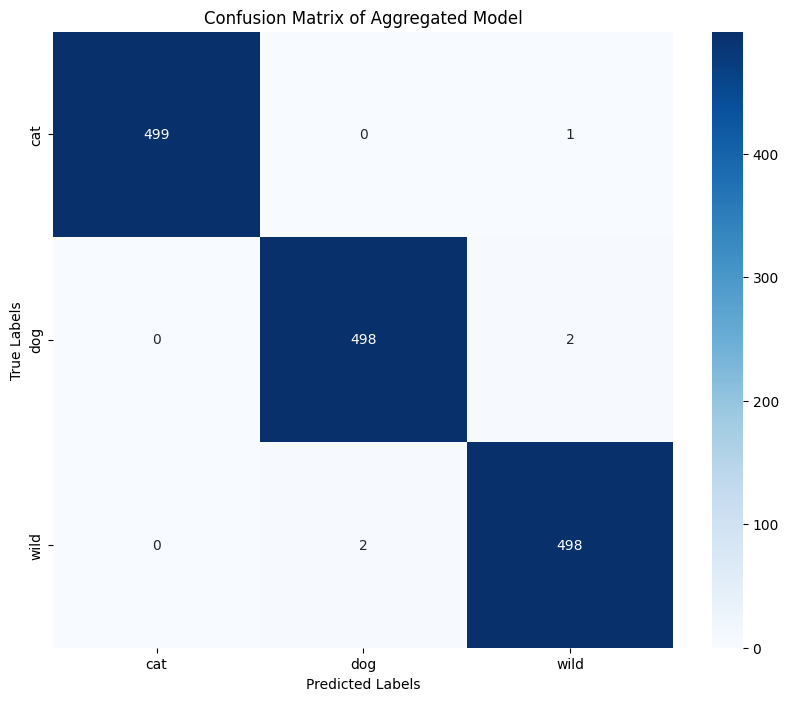

In [33]:
evaluate_aggregated_model(results, classes)